### Этап 0. Подготовка инструментов

In [1]:
import re
from collections import Counter
from functools import partial

import pandas as pd

In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

/home/ubuntu/sprint4/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from scripts.config import CONFIG
from scripts.EDA import analyze_num_cols, plot_images
from scripts.dataset import MultimodalDataset, collate_fn, get_transforms
from scripts.model import MultimodalModel
from scripts.utils import train, validate

In [4]:
RAW_DATASET_PATH = './data/dish.csv'
INGREDIENTS_DATA = './data/ingredients.csv'

### Этап 1. Загрузка и подготовка данных

In [5]:
df = pd.read_csv(RAW_DATASET_PATH)
df.head(5)

,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train


In [6]:
ing_df = pd.read_csv(INGREDIENTS_DATA)
ing_df.head(5)

,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes


In [7]:
ing_df['ingr_mod'] = ing_df['ingr'].apply(lambda text: re.sub(r'[^a-zA-Z ]', '', text))
ing_df.head(5)

,id,ingr,ingr_mod
0,1,cottage cheese,cottage cheese
1,2,strawberries,strawberries
2,3,garden salad,garden salad
3,4,bacon,bacon
4,5,potatoes,potatoes


In [8]:
def get_ingredient_names(ingredients: str) -> str:
    ingredients_list: list[str] = ingredients.split(';')
    ingredient_ids_list: list[int] = [int(ing.lstrip('ingr_').lstrip('0')) for ing in ingredients_list]
    ingredient_names_list: list[str] = [ing_df.loc[ing_id - 1]['ingr_mod'] for ing_id in ingredient_ids_list]
    return ' '.join(ingredient_names_list)

In [9]:
df['ingredient_names'] = df['ingredients'].apply(get_ingredient_names)
df.head(5)

,dish_id,total_calories,total_mass,ingredients,split,ingredient_names
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test,soy sauce garlic white rice parsley onions bro...
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train,pepper white rice mixed greens garlic soy sauc...
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test,jalapenos lemon juice pork wheat berry cabbage...
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train,cherry tomatoes cucumbers baby carrots
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train,deprecated


In [10]:
df['image_path'] = df['dish_id'].apply(lambda dish_id: f'./data/images/{dish_id}/rgb.png')
df.head(5)

,dish_id,total_calories,total_mass,ingredients,split,ingredient_names,image_path
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test,soy sauce garlic white rice parsley onions bro...,./data/images/dish_1561662216/rgb.png
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train,pepper white rice mixed greens garlic soy sauc...,./data/images/dish_1561662054/rgb.png
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test,jalapenos lemon juice pork wheat berry cabbage...,./data/images/dish_1562008979/rgb.png
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train,cherry tomatoes cucumbers baby carrots,./data/images/dish_1560455030/rgb.png
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train,deprecated,./data/images/dish_1558372433/rgb.png


In [11]:
df_train = df.drop('ingredients', axis=1).where(df['split'] == 'train').dropna()
df_test = df.drop('ingredients', axis=1).where(df['split'] == 'test').dropna()
print(f'Train size: {df_train.shape[0]}, Test size: {df_test.shape[0]}')

Train size: 2755, Test size: 507


In [12]:
df_train.head(5)

,dish_id,total_calories,total_mass,split,ingredient_names,image_path
1,dish_1561662054,419.438782,292.0,train,pepper white rice mixed greens garlic soy sauc...,./data/images/dish_1561662054/rgb.png
3,dish_1560455030,20.590000,103.0,train,cherry tomatoes cucumbers baby carrots,./data/images/dish_1560455030/rgb.png
4,dish_1558372433,74.360001,143.0,train,deprecated,./data/images/dish_1558372433/rgb.png
5,dish_1565640549,45.482903,139.0,train,tomatoes cilantro olive oil mustard greens lem...,./data/images/dish_1565640549/rgb.png
6,dish_1563207364,309.269989,271.0,train,scrambled eggs yam grapes egg whites olive oil...,./data/images/dish_1563207364/rgb.png


In [13]:
df_train.drop('split', axis=1).to_csv(CONFIG.TRAIN_DF_PATH, index=False)
df_test.drop('split', axis=1).to_csv(CONFIG.VAL_DF_PATH, index=False)

### Этап 2. Исследовательский анализ данных

In [14]:
data = pd.read_csv(CONFIG.TRAIN_DF_PATH)
data.head(5)

,dish_id,total_calories,total_mass,ingredient_names,image_path
0,dish_1561662054,419.438782,292.0,pepper white rice mixed greens garlic soy sauc...,./data/images/dish_1561662054/rgb.png
1,dish_1560455030,20.590000,103.0,cherry tomatoes cucumbers baby carrots,./data/images/dish_1560455030/rgb.png
2,dish_1558372433,74.360001,143.0,deprecated,./data/images/dish_1558372433/rgb.png
3,dish_1565640549,45.482903,139.0,tomatoes cilantro olive oil mustard greens lem...,./data/images/dish_1565640549/rgb.png
4,dish_1563207364,309.269989,271.0,scrambled eggs yam grapes egg whites olive oil...,./data/images/dish_1563207364/rgb.png


,total_calories,total_mass
count,2755.000000,2755.000000
mean,254.929131,218.011252
std,221.009051,163.089503
min,0.000000,5.000000
25%,81.805329,94.000000
50%,208.115997,179.000000
75%,376.573365,308.000000
max,3943.325195,3051.000000


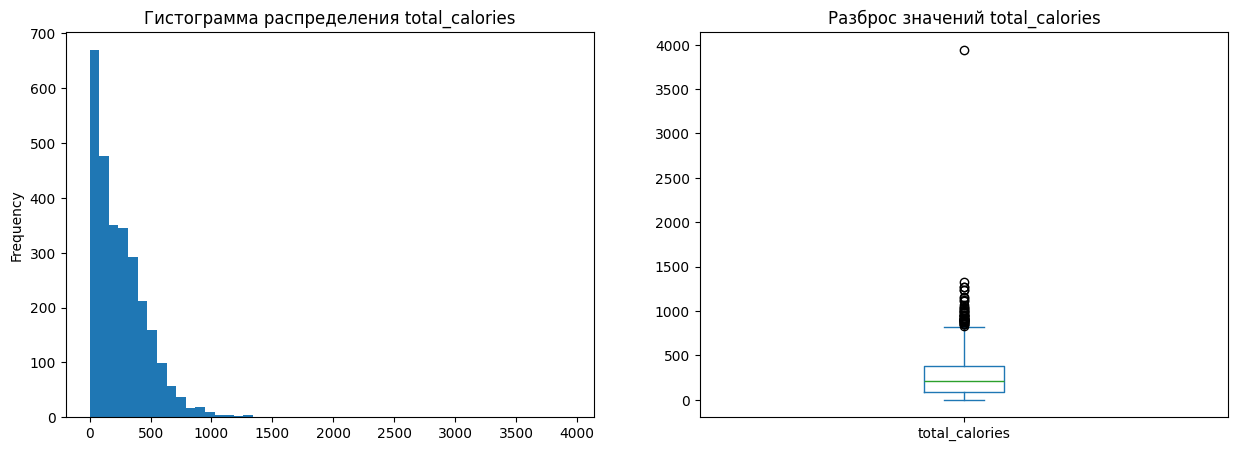

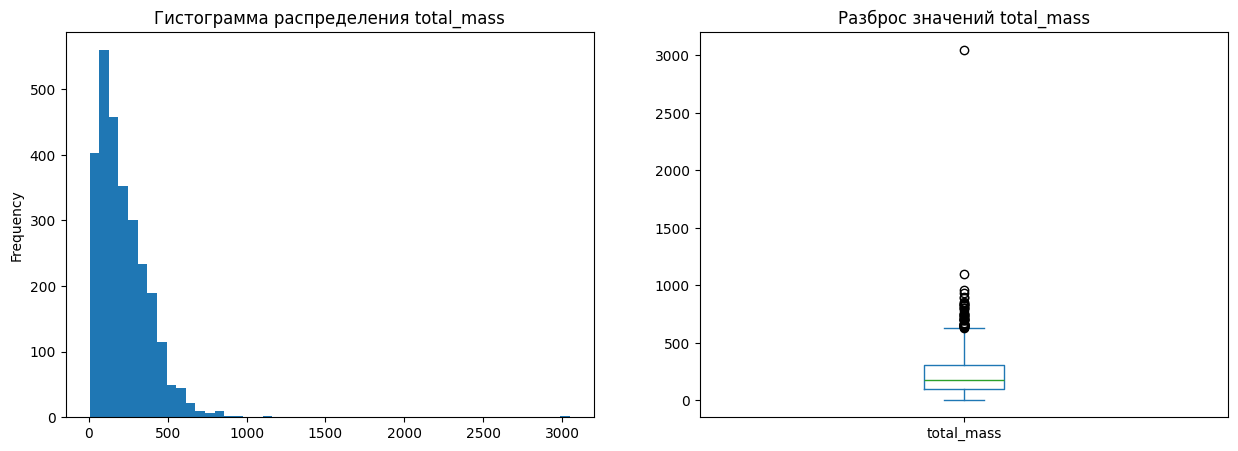

In [15]:
analyze_num_cols(data)

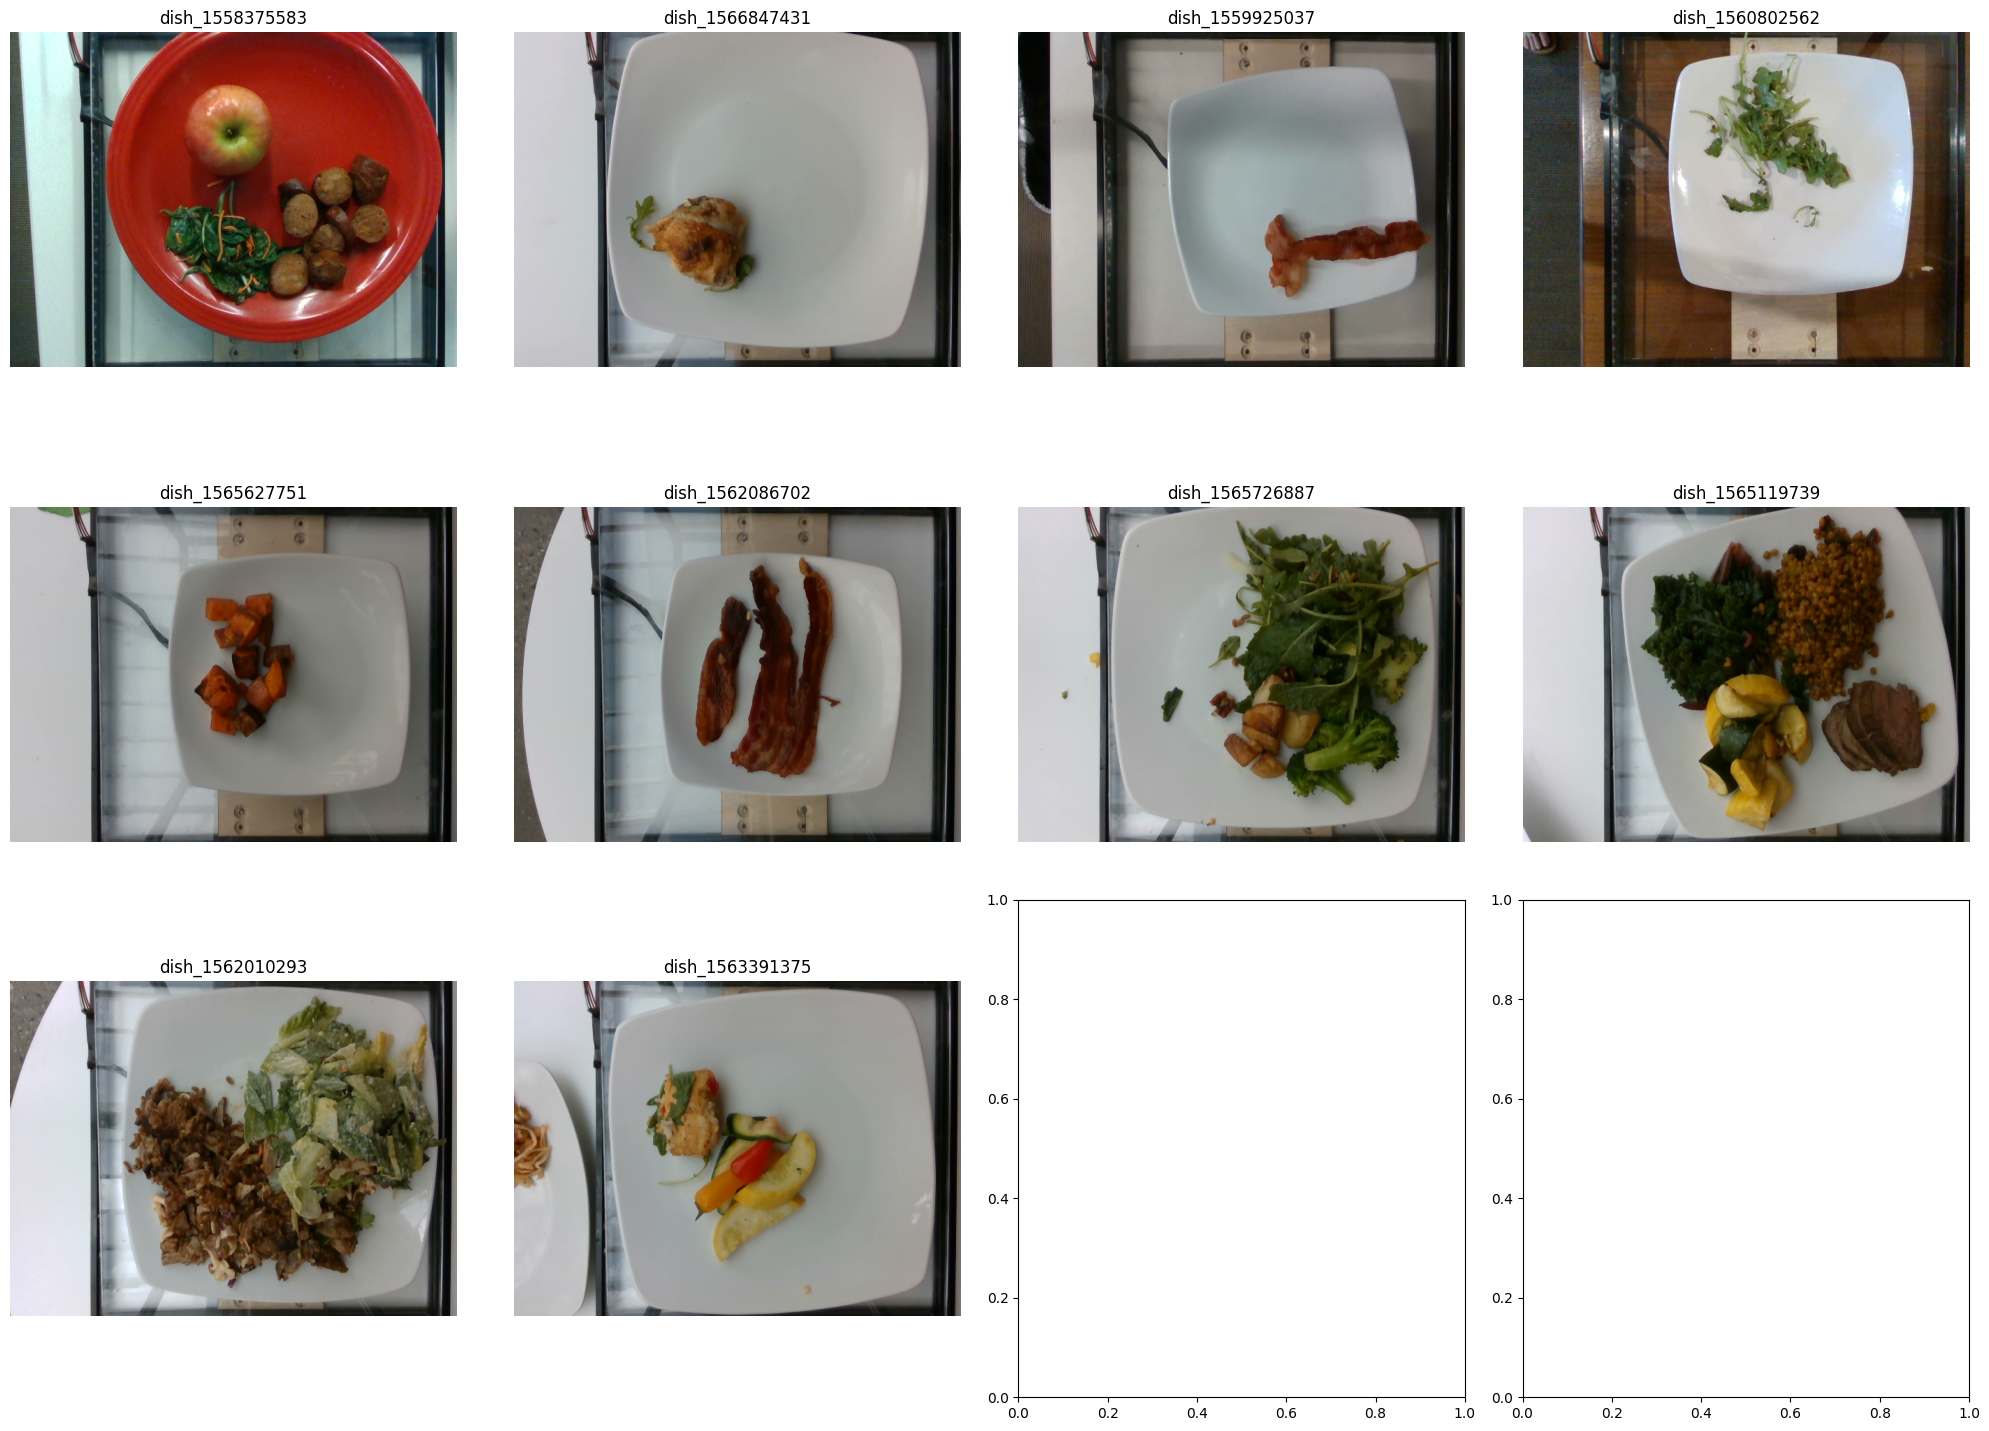

In [16]:
plot_images(data)

In [17]:
recipes = [recipe.split() for recipe in list(data['ingredient_names'])]
ingredients = [ingredient for recipe in recipes for ingredient in recipe]
ingredients_counts = Counter(ingredients)
print("Топ-10 ингредиентов: ", sorted(ingredients_counts, key=lambda elem: elem[1], reverse=True)[:10])

Топ-10 ингредиентов:  ['syrup', 'sweet', 'avocado', 'juice', 'sugar', 'cucumbers', 'mustard', 'mushroom', 'zucchini', 'turkey']


### Этап 3. Обучение модели

In [18]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
model = MultimodalModel(CONFIG).to(DEVICE)

In [20]:
tokenizer = AutoTokenizer.from_pretrained(CONFIG.TEXT_MODEL_NAME)

In [21]:
transforms = get_transforms(CONFIG)
val_transforms = get_transforms(CONFIG, ds_type="val")

In [22]:
train_dataset = MultimodalDataset(CONFIG, transforms)
val_dataset = MultimodalDataset(CONFIG, val_transforms, ds_type="val")

In [23]:
train_loader = DataLoader(
    train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, collate_fn=partial(collate_fn, tokenizer=tokenizer)
)
val_loader = DataLoader(
    val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, collate_fn=partial(collate_fn, tokenizer=tokenizer)
)

In [24]:
train(model, CONFIG, train_loader, val_loader, DEVICE)

/home/ubuntu/sprint4/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/home/ubuntu/sprint4/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/home/ubuntu/sprint4/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([59])) that is different to the input size (torch.Size([59, 1])). This will likely lead to incorrect r

Epoch 1/10 | Loss (train): 239.50510 | Loss (val): 175.81065
Epoch 2/10 | Loss (train): 167.51472 | Loss (val): 169.22893
Epoch 3/10 | Loss (train): 167.95677 | Loss (val): 169.21170
Epoch 4/10 | Loss (train): 168.42688 | Loss (val): 169.52527
Epoch 5/10 | Loss (train): 168.68712 | Loss (val): 169.00087
Epoch 6/10 | Loss (train): 166.79960 | Loss (val): 168.70506
Epoch 7/10 | Loss (train): 167.35334 | Loss (val): 168.45085
Epoch 8/10 | Loss (train): 165.62917 | Loss (val): 167.67158
Epoch 9/10 | Loss (train): 165.13709 | Loss (val): 167.38962
Epoch 10/10 | Loss (train): 165.80441 | Loss (val): 167.61221


### Этап 4. Валидация качества